In [6]:
import collections
import numpy as np
import pickle
import torch
from tqdm import tqdm
import wandb

import sys
sys.path.append('../')
import models
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from python_dict_wrapper import wrap
import torch
import seaborn as sns

import matplotlib

matplotlib.rcParams["font.family"] = "Arial"
matplotlib.rcParams['font.sans-serif'] = "Arial"
sns.set(font="Arial", style="ticks")

In [7]:
api = wandb.Api()

runs = api.runs("pmin/train_fmri_convex.py", 
                {"$and": 
                 [
                     {"config.dataset": {"$in": ["pvc1-repeats", "pvc4", "mt1_norm_neutralbg", "mt2", "mst_norm_neutralbg"]}},
                     {"config.aggregator": "downsample"},
                     {"config.pca": 500},
                     {"state": "finished"},
                ]
                }
               )

archives = {}

# Obtained using Sahani and Linden (2001) estimator
maxr2 = {'pvc1-repeats': np.array([0.5744896820822633, 0.402217859192537, 0.0724421977946134, 0.6354586579714803, 0.9058806806864625, 0.8336628618135512, 0.17459746284283278, 0.06161188996050254, 0.8174059944033387, 0.06870710384497566, 0.42338794910123256, -0.018763251412587834, 0.5083599168053451, 0.015472472397394084, 0.3707145547472778, 0.37212756865521673, 0.20308082812019865, 0.6502611134346646, 0.5865097550973541, 0.8000969058326385, 0.19490149480742838, 0.16097380666220693, 0.35043086612449575]),
         'mst_norm_neutralbg': np.array([0.9238747684974108, 0.6333767821204601, 0.7837951303681188, 0.5308424287543246, 0.6260003702050283, 0.1227297633207262, -0.008784291339639153, 0.969760707867131, 0.969760707867131, 0.934727465911976, 0.7529227717733953, 0.5552180843492884, 0.9697541232379692, 0.9697541232379692, 0.9568011354583447, 0.8665498339085808, 0.9760604082608981, 0.8886188901104971, 0.939593861110838, 0.7750084758128198, 0.8745374754975368, 0.31508570581933376, 0.7633260217238106, 0.42445345198910983, 0.37880214350624575, 0.7589317052993544, 0.8804914772347142, 0.6289593364765851, 0.8682772295743525, 0.953022447487612, 0.6817736539099156, 0.7436142187949378, 0.7436142187949378, 0.6583185135218004, -0.24862120717043004, 0.7360928676249001])}

print("Found %i" % len(runs))
for run in tqdm(runs):
    if run.config['features'] == 'SlowFast':
        if run.config['layer'] > 16:
            run.config['features'] = 'SlowFast_Fast'
            run.config['layer'] = run.config['layer'] - 17
        else:
            run.config['features'] = 'SlowFast_Slow'
    
    unique_name = f"{run.config['features']}_layer{int(run.config['layer']):02}_{run.config['dataset']}_{(run.config['subset'])}"
    if unique_name in archives:
        continue
        
    if 'corrs_report' in run.summary:
        maxr2_ = [1]
        if run.config['dataset'] in maxr2.keys():
            maxr2_ = [maxr2[run.config['dataset']][int(run.summary['subset'])]]
            
        archives[unique_name] = {'corrs_report': [run.summary['corrs_report']],
                                 'maxr2': maxr2_,
                                 'config': run.config,
                                }

  0%|          | 0/20225 [00:00<?, ?it/s]

Found 20225


100%|██████████| 20225/20225 [03:01<00:00, 111.52it/s]


Normalize names.

In [8]:
families = {'I3D': 'SlowFast',
            'MotionNet': 'control',
            'SlowFast_Fast': 'SlowFast',
            'SlowFast_Slow': 'SlowFast',
            'Slow': 'SlowFast',
            'Slow': 'SlowFast',
            'gaborpyramid3d': 'shallow',
            'gaborpyramid3d_motionless': 'control',
            'r3d_18': 'r3d',
            'mc3_18': 'r3d',
            'r2plus1d_18': 'r3d',
            'ShallowMonkeyNet_pvc1': 'dorsalnets',
            'ShallowMonkeyNet_pvc4': 'dorsalnets',
            'resnet18': 'control',
            'ShiftNet': 'control',
            'V1Net': 'dorsalnets',
            'dorsalnet': 'dorsalnets',
            'airsim_00': 'dorsalnets',
            'airsim_02': 'dorsalnets',
            'airsim_03': 'dorsalnets',
            'airsim_04': 'dorsalnets',
            'cpc': 'control',
            'cpc_01': 'control',
            'cpc_02': 'control'}

friendly_names = {'I3D': 'i3d',
                    'MotionNet': 'motionnet',
                    'SlowFast_Fast': 'slowfast',
                    'SlowFast_Slow': 'slowfast_slow',
                    'Slow': 'slow',
                    'gaborpyramid3d': 'gaborpyramid3d',
                    'gaborpyramid3d_motionless': 'gaborpyramid3d_motionless',
                    'r3d_18': 'r3d_18',
                    'mc3_18': 'mc3_18',
                    'r2plus1d_18': 'r2plus1d_18',
                    'ShallowMonkeyNet_pvc1': 'ShallowMonkeyNet_pvc1',
                    'ShallowMonkeyNet_pvc4': 'ShallowMonkeyNet_pvc4',
                    'resnet18': 'resnet18',
                    'ShiftNet': 'ShiftNet',
                    'V1Net': 'V1Net',
                    'dorsalnet': 'dorsalnets',
                    'airsim_00': 'dorsalnets',
                    'airsim_02': 'dorsalnets',
                    'airsim_03': 'dorsalnets',
                    'airsim_04': 'dorsalnet',
                    'cpc': 'cpc',
                    'cpc_01': 'cpc_airsim',
                    'cpc_02': 'cpc_ucf'}

whitelist = {
    'i3d': [0, 1, 2, 4, 6, 8],
    'slowfast': [0, 1, 2, 4, 6, 8],
    'motionnet': [0, 1],
    'gaborpyramid3d_motionless': [0],
    'gaborpyramid3d': [0],
    'mc3_18': [0, 1, 2, 4, 6, 8, 10, 12],
    'r2plus1d_18': [0, 1, 2, 4, 6, 8, 10, 12],
    'r3d_18': [0, 1, 2, 4, 6, 8, 10, 12],
    'cpc_airsim': [0, 1, 2, 4, 6, 8, 10, 12],
    'cpc_ucf': [0, 1, 2, 4, 6, 8, 10, 12],
    'dorsalnet': [0, 1, 2, 3, 4, 5],
}

dataset_names = {
    "pvc1-repeats": "pvc1",
    "pvc4": "pvc4", 
    "mt1_norm_neutralbg": "mt1", 
    "mt2": "mt2", 
    "mst_norm_neutralbg": "mst"
}

results = []
for k, v in archives.items():
    fam = families[v['config']['features']]
    try:
        layer_num = int(v['config']['layer_name'][-2:])
    except (KeyError, ValueError):
        layer_num = int(v['config']['layer'])

    friendly_name = friendly_names[v['config']['features']]
    if friendly_name not in whitelist.keys() or layer_num not in whitelist[friendly_name]:
        continue
        
    results += [{'key': k, 
                 'family': fam,
                 'dataset': dataset_names[v['config']['dataset']],
                 'subset': int(v['config']['subset']) + i*100,
                 'features': friendly_name,
                 'layer': layer_num,
                 'features_layer': f"{friendly_name}_{layer_num:02}",
                 'report_corr': x,
                 'max_r2': np.sqrt(max([m, .1])),
                 'rnorm': x / np.sqrt(max([m, .1]))} for i, (x, m) in enumerate(zip(v['corrs_report'], v['maxr2']))]

df = pd.DataFrame(results)
df = df.sort_values('key')
nums = df.groupby(['dataset', 'features', 'layer']).subset.count().reset_index()
df = df.merge(nums, left_on=('dataset', 'features', 'layer'), right_on=('dataset', 'features', 'layer'), suffixes=('', '_overall'))
df = df[df.subset_overall.isin([23, 25, 36, 44, 84])]
df.groupby(['dataset', 'subset_overall']).first()

,,key,family,subset,features,layer,features_layer,report_corr,max_r2,rnorm
dataset,subset_overall,,,,,,,,,
mst,36,I3D_layer00_mst_norm_neutralbg_0,SlowFast,0,i3d,0,i3d_00,0.271957,0.961184,0.282940
mt1,84,I3D_layer00_mt1_norm_neutralbg_0,SlowFast,0,i3d,0,i3d_00,0.035600,1.000000,0.035600
mt2,44,I3D_layer00_mt2_0,SlowFast,0,i3d,0,i3d_00,0.182025,1.000000,0.182025
pvc1,23,I3D_layer00_pvc1-repeats_0,SlowFast,0,i3d,0,i3d_00,0.150142,0.757951,0.198090
pvc4,25,I3D_layer00_pvc4_0,SlowFast,0,i3d,0,i3d_00,0.709660,1.000000,0.709660


# Key measurements table

In [9]:
#df_ = df.groupby(['dataset', 'features', 'layer']).rnorm.agg(['mean', 'sem', 'count'])
#df_.reset_index().groupby(['dataset', 'features'])['mean'].max()
datasets = df.dataset.unique()
perf = []
for dataset in datasets:
    df_ = df.query(f'dataset == "{dataset}"')
    df_m = df_.pivot_table('rnorm', 'features', 'layer')
    df_s = df_.pivot_table('rnorm', 'features', 'layer', aggfunc='sem')

    m = np.diag(df_m.loc[df_m.index, df_m.idxmax(axis=1)].values)
    s = np.diag(df_s.loc[df_s.index, df_m.idxmax(axis=1)].values)
    
    series = df_.groupby(['features_layer']).mean().report_corr
    best = series.index[series.argmax()]
    
    df_ = pd.merge(df_, df_.query(f'features_layer == "{best}"')[['subset', 'rnorm']], left_on='subset', right_on='subset', suffixes=('', '_best'))
    df_['rnorm_delta'] = df_['rnorm'] - df_['rnorm_best']
    df_m_delta = df_.pivot_table('rnorm_delta', 'features', 'layer')
    df_s_delta = df_.pivot_table('rnorm_delta', 'features', 'layer', aggfunc='sem') + 1e-6
    df_ = (df_m_delta / df_s_delta).max(axis=1)

    perf += [{'dataset': dataset, 
              'features': f, 
              'z': df_.loc[f],
              'm': mm, 
              's': ss} for f, mm, ss in zip(df_m.index, m, s)]

df_m = pd.DataFrame(perf).pivot('features', 'dataset', 'm')
df_s = pd.DataFrame(perf).pivot('features', 'dataset', 's')
df_z = pd.DataFrame(perf).pivot('features', 'dataset', 'z')

models = ['slowfast', 'i3d', 'r3d_18', 'r2plus1d_18', 'mc3_18',  'cpc_ucf', 'cpc_airsim', 'gaborpyramid3d_motionless', 'gaborpyramid3d',  'motionnet', 'dorsalnet']
datasets = ['pvc1', 'pvc4', 'mt1', 'mt2', 'mst']

df_m = df_m[datasets].loc[models]
df_s = df_s[datasets].loc[models]
df_z = df_z[datasets].loc[models]
    
the_str = f"\\begin{{tabular}}{{{'l' * (df_m.shape[1] + 1)}}}\n\\toprule \n"
the_str += '{} & ' + ' & '.join(df_m.columns.tolist()).replace('\\', '\\\\').replace('_', '\_') + '\\\\\n'
the_str += '\midrule \n'

for idx, row in df_m.iterrows():
    vals = [idx.replace('_', '\_')]
    for feature, v in row.items():
        if np.isnan(v):
            vals.append('-')
        else:
            if df_z.loc[idx, feature].item() < -1.96:
                vals.append(f"{v:.3f} ({df_s.loc[idx, feature]:.3f})"[1:])
            else:
                vals.append(f"\\textbf{{{v:.3f}}} ({df_s.loc[idx, feature]:.3f})")
                
    the_str += ' & '.join(vals) + '\\\\\n'

the_str += "\end{tabular}\n"
print(the_str)

\begin{tabular}{llllll}
\toprule 
{} & pvc1 & pvc4 & mt1 & mt2 & mst\\
\midrule 
slowfast & \textbf{0.471} (0.034) & .361 (0.042) & .211 (0.018) & .281 (0.015) & .189 (0.044)\\
i3d & \textbf{0.457} (0.036) & \textbf{0.389} (0.046) & .213 (0.018) & .284 (0.015) & .219 (0.044)\\
r3d\_18 & .403 (0.032) & \textbf{0.383} (0.042) & .217 (0.018) & .289 (0.015) & .224 (0.046)\\
r2plus1d\_18 & .428 (0.035) & \textbf{0.382} (0.042) & .215 (0.018) & .282 (0.015) & .226 (0.043)\\
mc3\_18 & .405 (0.034) & \textbf{0.393} (0.045) & .218 (0.018) & .276 (0.014) & .228 (0.045)\\
cpc\_ucf & .271 (0.044) & \textbf{0.394} (0.046) & .214 (0.018) & .241 (0.016) & .190 (0.045)\\
cpc\_airsim & .422 (0.036) & \textbf{0.384} (0.045) & \textbf{0.250} (0.020) & .360 (0.017) & .292 (0.045)\\
gaborpyramid3d\_motionless & .273 (0.035) & .353 (0.038) & .212 (0.018) & .188 (0.014) & .248 (0.045)\\
gaborpyramid3d & .325 (0.036) & \textbf{0.366} (0.037) & \textbf{0.249} (0.019) & .301 (0.015) & .394 (0.054)\\
motionnet &

# Bump plot

In [106]:
df['area'] = df.dataset.map(lambda x: dmap[x])
df_ = df.query('features == "dorsalnet"')

df_.groupby(['area', 'layer']).rnorm.mean()

area  layer
mst   0        0.171916
      1        0.307345
      2        0.441059
      3        0.454027
      4        0.447793
      5        0.430787
mt    0        0.145767
      1        0.241011
      2        0.295442
      3        0.291372
      4        0.281236
      5        0.260561
v1    0        0.132205
      1        0.356558
      2        0.361870
      3        0.338111
      4        0.307857
      5        0.275450
Name: rnorm, dtype: float64

<ipython-input-121-c0dc5608b2be>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['dataset_subset'] = df_.dataset + '_' + df_.subset.astype(np.str)


1.1434687499999998
0.1688649528094163
[0.83333333 1.14583333 1.5       ]


<ipython-input-121-c0dc5608b2be>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['dataset_subset'] = df_.dataset + '_' + df_.subset.astype(np.str)


2.0457889763779527
0.11259596081219249
[1.81889764 2.04724409 2.26771654]


<ipython-input-121-c0dc5608b2be>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_['dataset_subset'] = df_.dataset + '_' + df_.subset.astype(np.str)


2.878325
0.2825001366150112
[2.3125  2.875   3.40625]


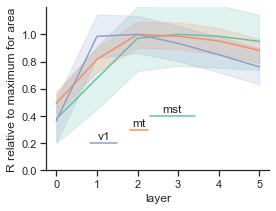

In [121]:
dmap = {'pvc1': 'v1', 'pvc4': 'v1', 'mt1': 'mt', 'mt2': 'mt', 'mst': 'mst'}

df['area'] = df.dataset.map(lambda x: dmap[x])
df_ = df.query('features == "dorsalnet"')
df_ = df_.sort_values('area', ascending=True)

df_['rnorm_max'] = df_.rnorm
df_.loc[df_.area == 'v1', 'rnorm_max'] /= .3618
df_.loc[df_.area == 'mt', 'rnorm_max'] /= .2954
df_.loc[df_.area == 'mst', 'rnorm_max'] /= .4540

plt.figure(figsize=(4, 3))
g = sns.lineplot(x='layer', 
                y='rnorm_max', 
                hue='area',
                palette="Set2",
                data=df_, legend=False, ax=plt.gca())
sns.despine()
#plt.legend(loc='upper right', fancybox=None, frameon=False, bbox_to_anchor=(0.,.3, 1.0, .105))
plt.ylabel('R relative to maximum for area')
plt.yticks([0, .2, .4, .6, .8, 1.0])
cols = sns.color_palette(as_cmap=True)
for i, area in enumerate(['v1', 'mt', 'mst']):
    df_ = df.query(f'report_corr > .01 and features == "dorsalnet" and area == "{area}"')
    df_['dataset_subset'] = df_.dataset + '_' + df_.subset.astype(np.str)
    v = df_.pivot('dataset_subset', 'layer', 'rnorm').values
    
    vals = []
    for n in range(10000):
        v_ = v[np.random.randint(low=0, high=v.shape[0], size=v.shape[0]), :].argmax(axis=1)#mean(axis=0)
        #cs = CubicSpline(np.arange(6), v_)
        #xs = np.linspace(0, 5)
        vals.append(v_.mean())
        
    print(np.mean(vals))
    print(np.std(vals))
    
    q = np.quantile(vals, [.025, .975])
    plt.plot(q, (.2 + .1*i) * np.array([1, 1]), color=g.lines[2-i].get_color())
    plt.text((q[0] + q[1])/2, .225 + .1*i, area, {'ha': 'center'})
    print(np.quantile(vals, [.025, .5, .975]))
    
plt.ylim([0, 1.2])

plt.savefig('/home/pmin/paper-assets/figure-2-layer-alignment.pdf', bbox_inches='tight')